<a href="https://colab.research.google.com/github/bigarcia/pece_eEDB-001_mineiracao_de_dados/blob/main/Projeto_Final_Previs%C3%A3o_de_Cancelamento_de_Reservas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Projeto Final - Previsão de Cancelamento de Reservas

### Alunos
Bianca Martins
Leander Silveira
Lucas Silva
Rodrigo Pedrosa

### Introdução
O setor hoteleiro enfrenta grandes desafios relacionados ao cancelamento de reservas, que podem impactar diretamente na lucratividade e eficiência operacional. Este trabalho utiliza técnicas de mineração de dados para prever cancelamentos com base em dados históricos de reservas, permitindo que hotéis criem estratégias proativas para mitigar esses impactos.

### Objetivo
1. Prever se uma reserva será cancelada com base em variáveis históricas.
2. Identificar os fatores mais relevantes que contribuem para o cancelamento.
3. Propor soluções baseadas nos resultados para mitigar cancelamentos e melhorar a eficiência.

## Importação de bibliotecas

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
import kagglehub


## 1. Carregar o Dataset


Nesta etapa, o conjunto de dados foi importado de uma fonte externa (Kaggle) e carregado em um DataFrame.

O dataset utilizado, de 119.390 registros, contém dados de reservas de hotéis e pode ser acessado pelo link do Kaggle: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

In [24]:

path = kagglehub.dataset_download("jessemostipak/hotel-booking-demand")
print("Path to dataset files:", path)
dataset_path = f"{path}/hotel_bookings.csv"

data = pd.read_csv(dataset_path)


data.head()

Path to dataset files: /root/.cache/kagglehub/datasets/jessemostipak/hotel-booking-demand/versions/1


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## 2. Análise Exploratória e Limpeza de Dados:



***Objetivo: Entender as características dos dados e preparar um conjunto limpo e estruturado para modelagem.***

Esse passo é utilizado para explorar os padrões nos dados e identificar relações entre variáveis. Visualizações como gráficos de distribuição e matriz de correlação ajudaram a destacar os fatores mais influentes no cancelamento de reservas, enquanto a análise estatística revelou inconsistências ou outliers. Também foram verificadas métricas como a proporção de reservas canceladas e não canceladas.

In [25]:
print("Informações do dataset:")
print(data.info())

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64

In [26]:
print("Estatísticas descritivas:")
print(data.describe())

Estatísticas descritivas:
         is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%              

### Tratamento de Valores Nulos


In [27]:
# Verificar a quantidade de valores nulos por coluna
print("Valores nulos por coluna:")
print(data.isnull().sum())

Valores nulos por coluna:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                          

In [28]:
# Remover linhas com valores nulos
# data.dropna(inplace=True) # Esse código removeu várias linhas e o dataset ficou pequeno

### Exclusão de Colunas Irrelevantes ou com muitos valores ausentes
data.drop(columns=['company', 'agent'], inplace=True, errors='ignore')

# Substituir valores nulos
data['children'] = data['children'].fillna(0)

### Análise de Distribuição de Cancelamentos


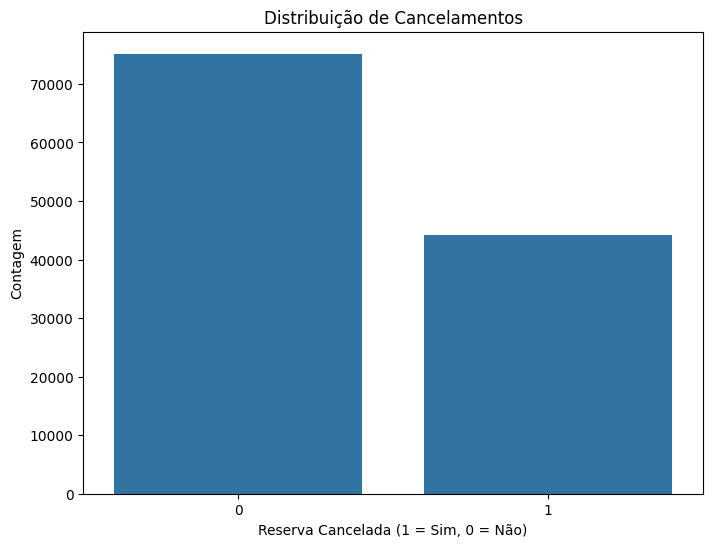

In [29]:
# Visualização da distribuição de reservas canceladas e não canceladas.

plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='is_canceled')
plt.title("Distribuição de Cancelamentos")
plt.xlabel('Reserva Cancelada (1 = Sim, 0 = Não)')
plt.ylabel('Contagem')
plt.show()

### Análise de Correlações


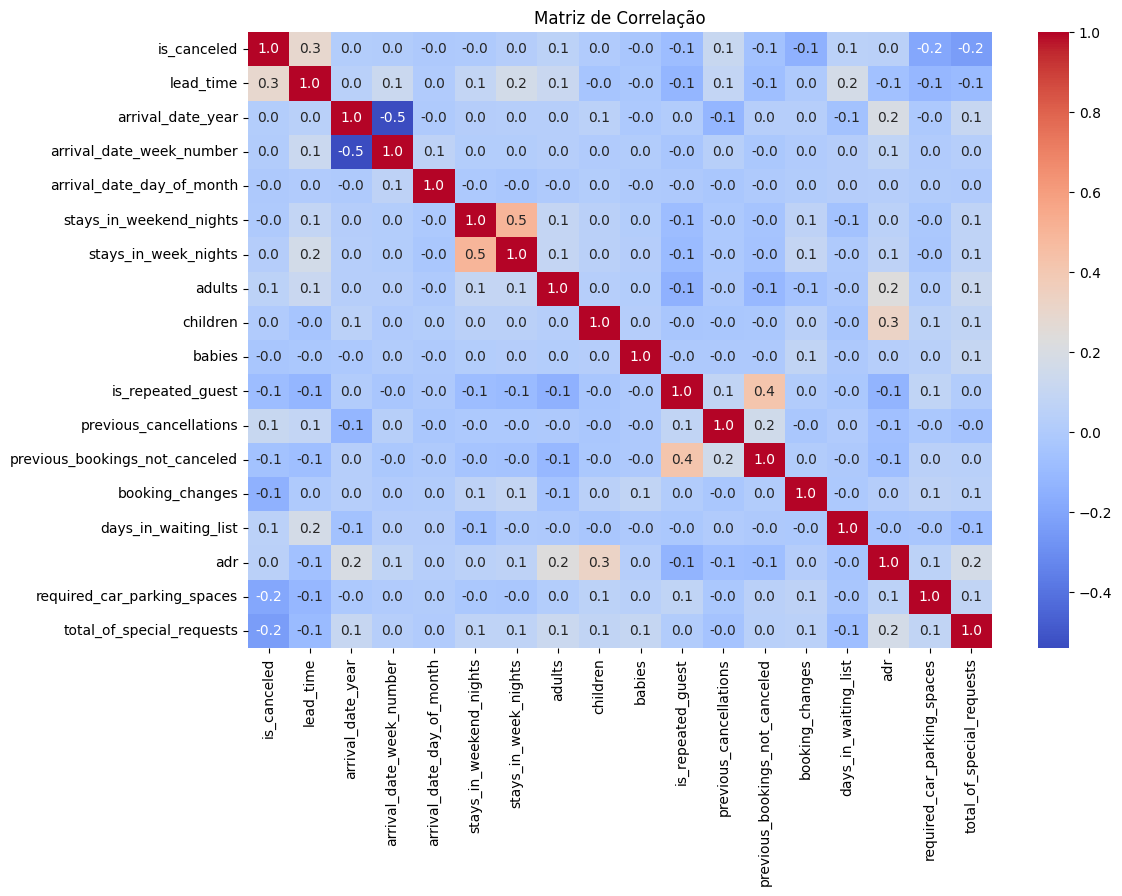

In [30]:
# Converter todas as colunas para numéricas, se necessário
data_numeric = data.select_dtypes(include=[np.number])

# Matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm', fmt='.1f')
plt.title("Matriz de Correlação")
plt.show()

In [31]:
# is_canceled = df_01.corr().loc['is_canceled', :].sort_values(ascending=False)

In [32]:
# is_canceled = is_canceled.loc[0.2:]

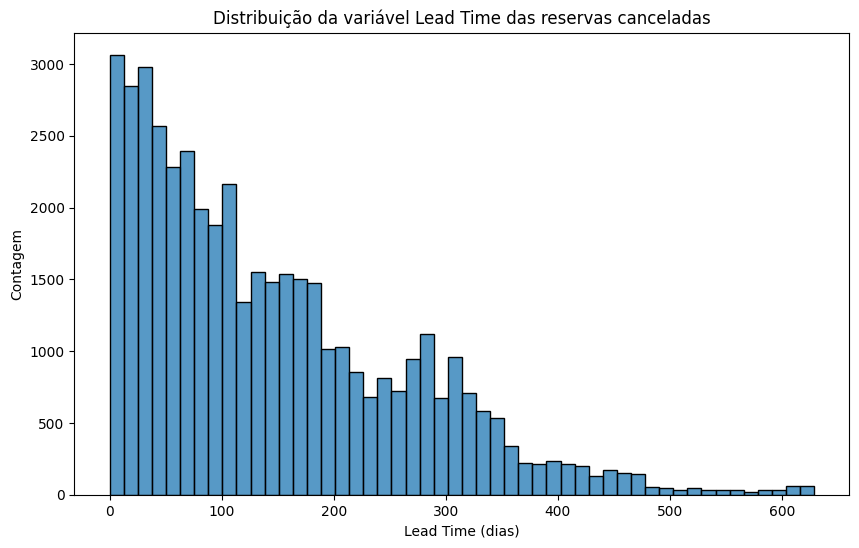

In [33]:
# Distribuição da variável Lead Time das reservas canceladas
plt.figure(figsize=(10, 6))
sns.histplot(data['lead_time'].loc[data['is_canceled']==1], bins=50)
plt.title('Distribuição da variável Lead Time das reservas canceladas')
plt.xlabel('Lead Time (dias)')
plt.ylabel('Contagem')
plt.show()

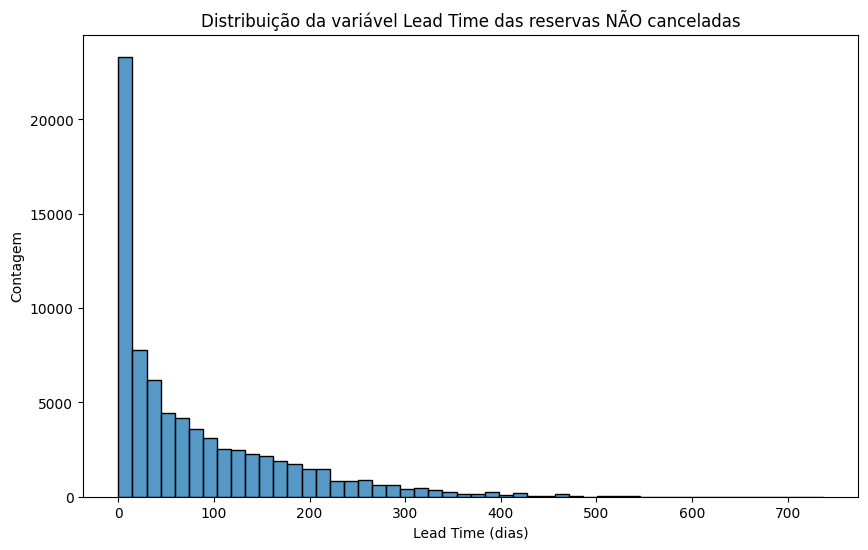

In [34]:
# Distribuição da variável Lead Time das reservas NÃO canceladas
plt.figure(figsize=(10, 6))
sns.histplot(data['lead_time'].loc[data['is_canceled']==0], bins=50)
plt.title('Distribuição da variável Lead Time das reservas NÃO canceladas')
plt.xlabel('Lead Time (dias)')
plt.ylabel('Contagem')
plt.show()

## 3. Feature Engineering

***Objetivo: Criar variáveis que melhor representem as características do dataset e sejam úteis para o modelo.***

O processo de engenharia de features envolveu a transformação e preparação dos dados para alimentar o modelo de machine learning.

Variáveis categóricas foram convertidas em variáveis numéricas utilizando one-hot encoding, valores ausentes foram tratados, e colunas irrelevantes ou redundantes foram removidas.

**Codificação One-Hot** é um método de transformar variáveis categóricas em representações numéricas, onde cada categoria é convertida em uma coluna binária (com valores 0 ou 1). Isso permite que algoritmos de aprendizado de máquina, que geralmente não conseguem lidar diretamente com texto, possam utilizar essas variáveis.

Além disso, o balanceamento das classes foi realizado com a técnica SMOTE para garantir que o modelo fosse treinado de forma justa.

**SMOTE (Synthetic Minority Over-sampling Technique)** é uma técnica que gera exemplos sintéticos para balancear classes desbalanceadas em datasets. Ele cria novas instâncias da classe minoritária interpolando entre exemplos reais e seus vizinhos mais próximos. Isso ajuda a reduzir o viés do modelo para a classe majoritária, melhora a generalização e evita a simples duplicação de dados. É amplamente usado em problemas de classificação onde a classe minoritária é importante, como detecção de fraudes e diagnósticos médicos.

In [35]:
# Transformamos variáveis categóricas em variáveis dummy para uso nos modelos de machine learning.
# categorical_features = ['hotel', 'arrival_date_month', 'meal', 'market_segment',
#                         'distribution_channel', 'reserved_room_type', 'assigned_room_type',
#                         'deposit_type', 'customer_type', 'reservation_status']

# data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Gerar variáveis dummies
data = pd.get_dummies(data, drop_first=True)

# Separar variáveis independentes e dependentes
X = data.drop('is_canceled', axis=1)
y = data['is_canceled']


In [36]:
# Balanceamento das classes com SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


**Dividir dados em treino e teste:**


*   Treinar o modelo em um subconjunto dos dados (X_train, y_train).
*   Testar o modelo em dados nunca vistos durante o treinamento (X_test, y_test).
Parametros:
*   `test_size=0.3`: Define a proporção dos dados reservados para o teste: 30% dos dados irão para o conjunto de teste (X_test, y_test),  70% dos dados serão usados no treinamento (X_train, y_train).
*   `random_state=42`: Define a aleatoriedade: Garantia de que a divisão seja reproduzível. Ao executar o código novamente, os mesmos subconjuntos serão gerados.

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
y

,is_canceled
0,0
1,0
2,0
3,0
4,0
...,...
150327,1
150328,1
150329,1
150330,1


In [38]:
df_y = pd.DataFrame(y)
df_y.head()

,is_canceled
0,0
1,0
2,0
3,0
4,0


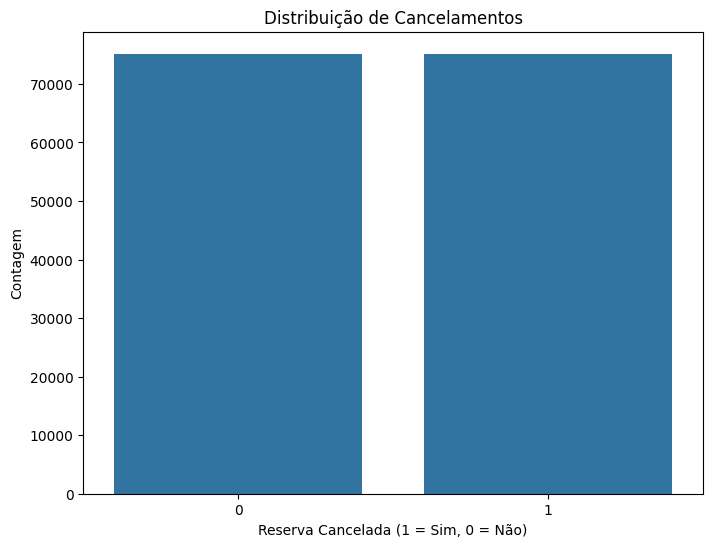

In [39]:
# Visualização da distribuição de reservas canceladas e não canceladas.

plt.figure(figsize=(8, 6))
sns.countplot(data=df_y, x='is_canceled')
plt.title("Distribuição de Cancelamentos")
plt.xlabel('Reserva Cancelada (1 = Sim, 0 = Não)')
plt.ylabel('Contagem')
plt.show()

In [40]:
# Deve retornar um conjunto vazio
# Certificando de que os dados de treino e teste são distintos:

print(set(X_train.index) & set(X_test.index))

set()


## 4. Treinamento

***Objetivo: Desenvolver um modelo capaz de aprender os padrões nos dados e prever novos casos.***

O treinamento do modelo foi realizado utilizando o algoritmo Random Forest, que é conhecido por sua robustez, capacidade de lidar com variáveis categóricas e interpretar interações complexas entre as features. Inicialmente, o conjunto de dados foi dividido em duas partes: 80% para treinamento e 20% para teste, garantindo que o modelo fosse avaliado em dados independentes e representativos do problema.

Durante o treinamento, o modelo recebeu como entrada as variáveis preditoras (como tipo de hotel, lead time, número de hóspedes, entre outras), enquanto a variável alvo foi o status de cancelamento da reserva (0 para não cancelada e 1 para cancelada). O algoritmo construiu múltiplas árvores de decisão, cada uma treinada em diferentes subconjuntos dos dados, e combinou as previsões dessas árvores para obter um resultado final mais preciso e robusto.


**Explicação do código:**


Função GridSearchCV: testará todas as combinações possíveis dos valores passados por param_grid

*   RandomForestClassifier: Define o modelo base que será treinado.
*   param_grid: Especifica os valores a serem testados para cada hiperparâmetro.
*   cv=5: Realiza validação cruzada com 5 divisões nos dados de treino. Cada combinação de hiperparâmetros será avaliada em 5 diferentes subconjuntos dos dados de treino.
*   scoring='roc_auc': Usa a métrica AUC (Área Sob a Curva ROC) para avaliar o desempenho de cada combinação de hiperparâmetros.

Método fit:
*   Treina o modelo Random Forest para cada combinação de valores definidos em param_grid.
*   Avalia o desempenho de cada combinação usando validação cruzada.
*   Seleciona a combinação de hiperparâmetros com a melhor pontuação (neste caso, o maior AUC).

O atributo best_estimator_ contém o modelo treinado com os melhores hiperparâmetros encontrados pela busca.


In [43]:
# Treinamento do modelo de Random Forest para prever cancelamentos.
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [55]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)
model = grid_search_rf.best_estimator_
print("Melhores hiperparâmetros para Random Forest:", grid_search_rf.best_params_)

Melhores hiperparâmetros para Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


## Importância das features
***Objetivo: Entender os principais fatores que contribuem para o cancelamento***


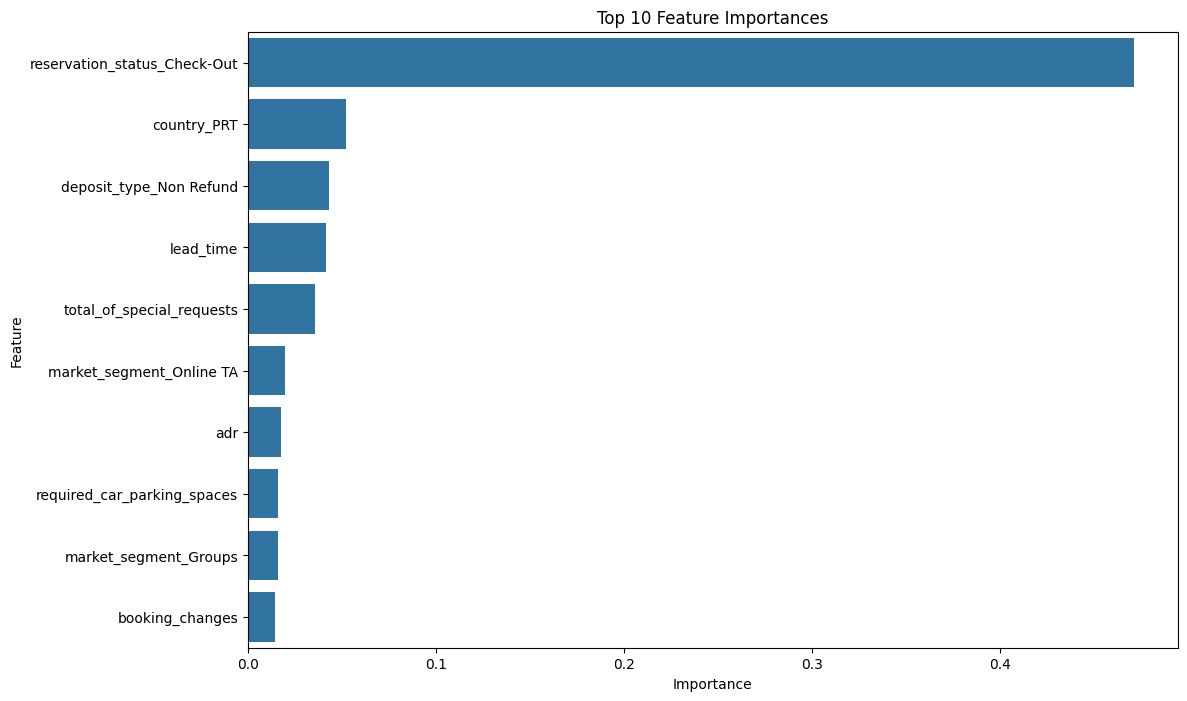

In [45]:
# Plot feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices][:10], y=features[indices][:10])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## 5. Avaliação do modelo
*** Objetivo: Medir o quão bem o modelo consegue prever cancelamentos. ***


A avaliação do modelo foi realizada com base em nas métricas de ***Relatório de Classificação, Matriz de Confusão e AUC-ROC***:





### Relatório de Classificação
O **Relatório de Classificação** fornece métricas detalhadas que avaliam o desempenho do modelo para cada classe do problema (reservas canceladas e não canceladas). Ele inclui as seguintes métricas principais:

Leia mais em: https://medium.com/@mateuspdua/machine-learning-m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-e-recall-d44c72307959

** Precision (Precisão)**: Mede a proporção de previsões corretas para uma classe específica em relação ao total de previsões feitas para essa classe. Alta precisão indica que o modelo raramente classifica uma reserva como cancelada (ou não cancelada) de forma errada.
  
$$
Precision = \frac{TP}{TP + FP}
$$


** Recall (Revocação ou Sensibilidade)**: Mede a proporção de verdadeiros positivos identificados em relação ao total de instâncias reais da classe. Alta revocação significa que o modelo detecta bem os casos positivos.

$$
Recall = \frac{TP}{TP + FN}
$$

** F1-Score**: É a média harmônica entre precisão e revocação. Essa métrica é útil quando há um trade-off entre precisão e revocação, indicando o equilíbrio entre ambas.

$$
F1 = F1\text{-}Score = 2 \cdot \frac{\text{Precisão} \cdot \text{Recall}}{\text{Precisão} + \text{Recall}}
$$

** Support (Suporte)**: Indica o número de instâncias reais de cada classe no conjunto de dados de teste.
Por exemplo:

Se no conjunto de teste houver 500 reservas canceladas e 1500 reservas não canceladas, o suporte seria:
Classe 0 (Não Cancelada): 1500
Classe 1 (Cancelada): 500


In [46]:
y_pred = model.predict(X_test)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22669
           1       1.00      1.00      1.00     22431

    accuracy                           1.00     45100
   macro avg       1.00      1.00      1.00     45100
weighted avg       1.00      1.00      1.00     45100



### Matriz de Confusão
   - Essa métrica foi usada para entender como o modelo classificou corretamente as reservas canceladas e não canceladas.
   - Ela apresentou um número perfeito de **Verdadeiros Positivos (TP)** e **Verdadeiros Negativos (TN)**, sem erros de classificação, ou seja, sem **Falsos Positivos (FP)** ou **Falsos Negativos (FN)**.
   - Isso indica que o modelo é confiável tanto para prever corretamente reservas canceladas quanto para evitar alarmes falsos.

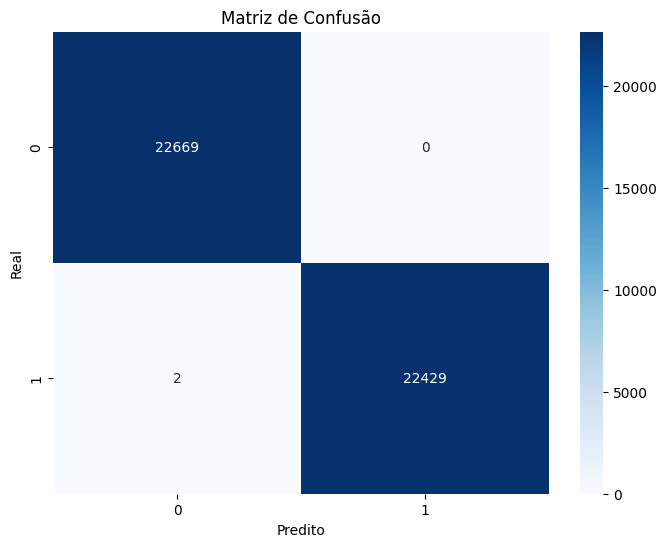

In [47]:
# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão")
plt.ylabel("Real")
plt.xlabel("Predito")
plt.show()



### Curva ROC e AUC
   - A curva ROC mediu a capacidade do modelo de distinguir entre as classes (cancelada e não cancelada) em diferentes limiares.
   - A **AUC (Área Sob a Curva)** foi de **1.00**, indicando que o modelo separa perfeitamente as classes, sem sobreposição entre elas.

Para realizar previsões com este modelo, basta fornecer os dados de entrada no mesmo formato utilizado durante o treinamento (após pré-processamento). O modelo pode ser utilizado com os métodos:
- **`predict`**: Retorna 0 ou 1, indicando se a reserva será ou não cancelada.
- **`predict_proba`**: Retorna as probabilidades associadas a cada classe, permitindo maior flexibilidade para ações estratégicas.

Esses resultados destacam que o modelo é altamente confiável para prever cancelamentos, com potencial direto de aplicação prática no setor hoteleiro, auxiliando na otimização operacional e na criação de estratégias para minimizar cancelamentos.


In [48]:
# Evaluate model using cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f'Cross-validated ROC AUC scores: {cv_scores}')
print(f'Mean ROC AUC score: {np.mean(cv_scores)}')

Cross-validated ROC AUC scores: [1. 1. 1. 1. 1.]
Mean ROC AUC score: 1.0


In [52]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate using ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {roc_auc}')

ROC AUC Score: 1.0


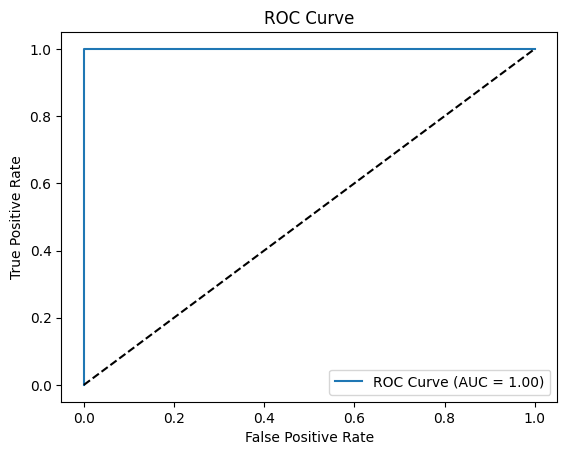

In [54]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

## Testando Outros Modelos e Ajustando Hiperparâmetros
Para validar ainda mais os resultados e verificar a robustez do modelo, serão testados outros algoritmos de aprendizado de máquina, como **Gradient Boosting** e **SVM (Support Vector Machine)**. Além disso, será realizado ajuste de hiperparâmetros para melhorar o desempenho preditivo.

### Modelo Gradient Boosting

O Gradient Boosting é um algoritmo de aprendizado supervisionado baseado em árvores de decisão, que combina várias árvores simples (fracas) para formar um modelo robusto e preciso. Ele funciona treinando cada nova árvore para corrigir os erros das árvores anteriores, utilizando o gradiente do erro como orientação.

In [ ]:
# Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train, y_train)


### Modelo Support Vector Machine (SVM)

O Support Vector Machine é um algoritmo de classificação e regressão que busca encontrar um hiperplano ótimo para separar classes no espaço de características. Ele utiliza pontos próximos ao limite de separação, chamados de vetores de suporte, para definir o hiperplano.



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])
model_svm.fit(X_train, y_train)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = auc(*roc_curve(y_test, y_pred_proba)[:2])
    print(classification_report(y_test, y_pred))
    return roc_auc

roc_auc_gb = evaluate_model(model_gb, X_test, y_test)
roc_auc_svm = evaluate_model(model_svm, X_test, y_test)

print(f"Gradient Boosting AUC = {roc_auc_gb:.2f}")
print(f"SVM AUC = {roc_auc_svm:.2f}")

## 6. Conclusão

O projeto de previsão de cancelamento de reservas em hotéis demonstrou como a mineração de dados pode ajudar na tomada de decisão, permitindo identificar padrões relevantes e melhorar o planejamento operacional. Durante o processo, foram aplicadas técnicas de engenharia de features, análise exploratória de dados e validação de modelos, resultando em insights valiosos sobre os principais fatores associados ao cancelamento de reservas.

Entre os modelos testados, o Random Forest apresentou um desempenho sólido, evidenciado pelas métricas de avaliação, como AUC e o relatório de classificação. A análise da importância das features revelou variáveis cruciais para prever cancelamentos, permitindo que os gestores de hotéis possam adotar estratégias mais informadas para minimizar cancelamentos e maximizar a receita.

Testes com outros modelos, como Gradient Boosting e SVM, complementaram a análise e reforçaram a confiabilidade dos resultados. No futuro, recomenda-se explorar a otimização de hiperparâmetros e incorporar dados adicionais para refinar ainda mais a precisão do modelo. Este projeto destaca o potencial da ciência de dados na solução de problemas reais e estratégicos no setor de hospitalidade.
